**function toy_model_new** ($w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2$)\
return Loss
     
**function toy_model_pop_solve** ($\alpha_1, \alpha_2, β_1, β_2, δ_1, δ_2$)\
return JuMP.value($w_1$), JuMP.value($w_2$), JuMP.value($p_1$), JuMP.value($p_2$), JuMP.value($Pop_1$), JuMP.value($Pop_2$)
     
**function toy_model_solve_2** ($w_1, w_2, p_1, p_2, Pop_1, Pop_2$)\
return JuMP.value($\alpha$_1), JuMP.value($\alpha$_2), JuMP.value($\beta$_1), JuMP.value($\beta$_2), JuMP.value($\delta$_1), JuMP.value($\delta$_2)
      
**function toy_model_pop_outer** ($w_1, w_2, p_1, p_2, Pop_1, Pop_2$)\
return Outer_Loss
     
**function toy_model_outer_solve** ()\
return 6 parameters values ($α_1, \alpha_2, β_1, \beta_2, δ_1, \delta_2$)



only toy_model_outer_solve() is run at the end :
 - It solves toy_model_solve_2 for $w_{1, target},w_{2, target},p_{1, target},p_{2, target},Pop_{1, target},Pop_{1, target}$ $\longrightarrow$ minimizes the squared differences in supplies and demands for $w_{1, target},w_{2, target},p_{1, target},p_{2, target},Pop_{1, target},Pop_{1, target}$ set and returns $\alpha_1^o, \alpha_2^o,\beta_1^o, \beta_2^o, \delta_1^o, \delta_2^o$
 - $\alpha_1^o, \alpha_2^o,\beta_1^o, \beta_2^o, \delta_1^o, \delta_2^o$ are the initial values for the Outer_Loss solver
 - Constraints for Outer_Loss solver :
     - $w_1, w_2, p_1, p_2, Pop_1, Pop_2 \geq 0$
     - $Loss_1 = (LS_1 - LD_1)^2 \simeq 0$
     - $Loss_2 = (LS_2 -LD_2)^2 \simeq 0$
     - $Loss_3 = (Hf_1 + Hh_1 - HT_1)^2 \simeq 0$
     - $Loss_4 = (Hf_2 + Hh_2 - HT_2)^2 \simeq 0$
     - $\Rightarrow Loss = Loss_1 + loss_2 + Loss_3 + Loss_4 \simeq 0$
 - It solves toy_model_pop_outer (= minimizes the squared differences in moments) while it observes the constraints (minimizes the squared differences in supplies and demands).


In [1]:
using Pkg, Optim, Ipopt, JuMP, Test, Printf, Plots

# Functions

In [2]:
# Function toy_model computes the loss function for given values of w_1, w_2, p_1, p_2, Pop_1, Pop_2
# and some parameters values

function toy_model_new(w_1::Real, w_2::Real, p_1::Real, p_2::Real, Pop_1::Real, Pop_2::Real,
     α_1, α_2, β_1, β_2, δ_1, δ_2)
     
    #---------------------------
    # FUNCTIONS
    #---------------------------
    ## Labor demand in m = 1, 2 ---
    LD_1::Real = 1.0 + α_1 * w_1 + α_2 * w_1^2
    LD_2::Real = 1.0 + α_1 * w_2 + α_2 * w_2^2
    ## Commutes between 1 & 2 ---
    M_12::Real = max( Pop_1 * (w_2 - w_1)/w_1 , 0)
    M_21::Real = max( Pop_2 * (w_1 - w_2)/w_2 , 0)
    ## Labor supply ---
    LS_1::Real = Pop_1 - M_12 + M_21
    LS_2::Real = Pop_2 - M_21 + M_12
    ## Housing demand of firms 
    Hf_1::Real = 1.0 + β_1 * p_1 + β_2 * p_1^2
    Hf_2::Real = 1.0 + β_1 * p_2 + β_2 * p_2^2
    ## Housing demand of households  
    Hh_1::Real = Pop_1 * (0.3 * (w_1) / p_1)
    Hh_2::Real = Pop_2 * (0.3 * (w_2) / p_2)
    ## Housing supply 
    HT_1::Real = 0.2 + δ_1 * p_1 + δ_2 * p_1^2
    HT_2::Real = 0.2 + δ_1 * p_2 + δ_2 * p_2^2
    
    #---------------------------
    # Equilibrium conditions
    #---------------------------
    ## We will search for wages and housing prices solving this equilibrium 

    ## Labor supply --
    Loss_1::Real = (LS_1 - LD_1)^2
    Loss_2::Real = (LS_2 - LD_2)^2
    ## Housing market clearing --
    Loss_3::Real = (Hf_1 + Hh_1 - HT_1)^2
    Loss_4::Real = (Hf_2 + Hh_2 - HT_2)^2
    
    Loss::Real = Loss_1 + Loss_2 + Loss_3 + Loss_4
    return Loss
    
end

toy_model_new (generic function with 1 method)

In [3]:
# Function toy_model_pop_solve finds equilibrium values for w_1, w_2, p_1, p_2, Pop_1, Pop_2
# for given values of parameters α_1, α_2, β_1, β_2, δ_1, δ_2

function toy_model_pop_solve(o_a_1::Real, o_a_2::Real, o_β_1::Real, o_β_2::Real, o_δ_1::Real, o_δ_2::Real)
    @printf "Begin solver execution\n"

    @printf "Initializing model in solver\n"
    toy = Model(Ipopt.Optimizer)        # define empty model solved by Ipopt algorithm

    register(toy, :toy_model_new, 12, toy_model_new; autodiff = true)

    @variable(toy, w_1, start = 100.)
    @variable(toy, w_2, start = 100.)
    @variable(toy, p_1, start = 10.)
    @variable(toy, p_2, start = 10.)
    @variable(toy, Pop_1, start = 100.)
    @variable(toy, Pop_2, start = 200.)
    @NLconstraint(toy, w_1 >= 0)
    @NLconstraint(toy, w_2 >= 0)
    @NLconstraint(toy, p_1 >= 0)
    @NLconstraint(toy, p_2 >= 0)
    @NLconstraint(toy, Pop_1 >= 0)
    @NLconstraint(toy, Pop_2 >= 0)
    @NLparameter(toy, α_1 == o_a_1)
    @NLparameter(toy, α_2 == o_a_2)
    @NLparameter(toy, β_1 == o_β_1)
    @NLparameter(toy, β_2 == o_β_2)
    @NLparameter(toy, δ_1 == o_δ_1)
    @NLparameter(toy, δ_2 == o_δ_2)

    # next, we set an objective function
    @NLobjective(toy, Min, toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2))

    @printf "Model initialized\n"

    @printf "Launching optimization\n"
    JuMP.optimize!(toy)
    @printf "Optimization complete\n"
    @printf "Results\n"

    println("RESULTS:")
    println(" $(w_1) = $(JuMP.value(w_1)) ")
    println(" $(w_2) = $(JuMP.value(w_2)) ")
    println(" $(p_1) = $(JuMP.value(p_1)) ")
    println(" $(p_2) = $(JuMP.value(p_2)) ")
    println(" $(Pop_1) = $(JuMP.value(Pop_1)) ")
    println(" $(Pop_2) = $(JuMP.value(Pop_2)) ")

    return (JuMP.value(w_1), JuMP.value(w_2), JuMP.value(p_1), JuMP.value(p_2), JuMP.value(Pop_1), JuMP.value(Pop_2))

end

toy_model_pop_solve (generic function with 1 method)

In [4]:
# Function toy_model_pop_outer computes the outer_loss function 
# for given values  w_1, w_2, p_1, p_2, Pop_1, Pop_2 

function toy_model_pop_outer(w_1_opt, w_2_opt, p_1_opt, p_2_opt, Pop_1_opt, Pop_2_opt)

    Outer_Loss_1::Real=(w_1_opt-w_1_target)^2
    Outer_Loss_2::Real=(w_2_opt-w_2_target)^2
    Outer_Loss_3::Real=(p_1_opt-p_1_target)^2
    Outer_Loss_4::Real=(p_2_opt-p_2_target)^2
    Outer_Loss_5::Real=(Pop_1_opt-Pop_1_target)^2
    Outer_Loss_6::Real=(Pop_2_opt-Pop_2_target)^2
    
    Outer_Loss = Outer_Loss_1 + Outer_Loss_2 + Outer_Loss_3 + Outer_Loss_4 + Outer_Loss_5 + Outer_Loss_6
    return Outer_Loss
    
end

toy_model_pop_outer (generic function with 1 method)

In [5]:
# Function toy_model_pop_solve finds equilibrium values of parameters α_1, α_2, β_1, β_2, δ_1, δ_2
# for given values w_1, w_2, p_1, p_2, Pop_1, Pop_2 

function toy_model_solve_2(aw_1, aw_2, ap_1, ap_2, aPop_1, aPop_2)

    toy = Model(Ipopt.Optimizer)        # define empty model solved by Ipopt algorithm
    set_silent(toy)

    register(toy, :toy_model_new, 12, toy_model_new; autodiff = true)

    @NLparameter(toy, w_1 == aw_1)
    @NLparameter(toy, w_2 == aw_2)
    @NLparameter(toy, p_1 == ap_1)
    @NLparameter(toy, p_2 == ap_2)
    @NLparameter(toy, Pop_1 == aPop_1)
    @NLparameter(toy, Pop_2 == aPop_2)
    @variable(toy, α_1, start = 0.)
    @variable(toy, α_2, start = 0.)
    @variable(toy, β_1, start = 0.)
    @variable(toy, β_2, start = 0.)
    @variable(toy, δ_1, start = 0.)
    @variable(toy, δ_2, start = 0.)

    # next, we set an objective function
    @NLobjective(toy, Min, toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2))

    JuMP.optimize!(toy)

    return(JuMP.value(α_1), JuMP.value(α_2), JuMP.value(β_1), JuMP.value(β_2), JuMP.value(δ_1), JuMP.value(δ_2))
    
end

toy_model_solve_2 (generic function with 1 method)

In [6]:
# Function toy_model_outer_solve the model using moments
# = finds parameters values which minimize the gap between observed moments and model moments,
# that is equilibrium values of w_1, w_2, p_1, p_2, Pop_1, Pop_2

function toy_model_outer_solve()   
    
    α_1_start, α_2_start, β_1_start, β_2_start, δ_1_start, δ_2_start = toy_model_solve_2(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target)
    
    println(" α_1_init = $(α_1_start) ")
    println(" α_2_init = $(α_2_start) ")
    println(" β_1_init = $(β_1_start) ")
    println(" β_2_init = $(β_2_start) ")
    println(" δ_1_init = $(δ_1_start) ")
    println(" δ_2_init = $(δ_2_start) ")
    
    Outer_toy = Model(Ipopt.Optimizer)            # define empty model solved by Ipopt algorithm
    set_attribute(Outer_toy, "print_level", 4)

    register(Outer_toy, :toy_model_pop_outer, 6, toy_model_pop_outer; autodiff = true)
    println("Model initialized\n")

    @variable(Outer_toy, α_1, start = α_1_start)
    @variable(Outer_toy, α_2, start = α_2_start)
    @variable(Outer_toy, β_1, start = β_1_start)
    @variable(Outer_toy, β_2, start = β_2_start)
    @variable(Outer_toy, δ_1, start = δ_1_start)
    @variable(Outer_toy, δ_2, start = δ_2_start)
    
    @variable(Outer_toy, w_1 >= 0, start = w_1_target)
    @variable(Outer_toy, w_2 >= 0, start = w_2_target)
    @variable(Outer_toy, p_1 >= 0, start = p_1_target)
    @variable(Outer_toy, p_2 >= 0, start = p_2_target)
    @variable(Outer_toy, Pop_1 >= 0, start = Pop_1_target)
    @variable(Outer_toy, Pop_2 >= 0, start = Pop_2_target)
    
    @NLconstraint(Outer_toy, (Pop_1 - (max( Pop_1 * (w_2 - w_1)/w_1 , 0)) + (max( Pop_2 * (w_1 - w_2)/w_2 , 0)) - (1.0 + α_1 * w_1 + α_2 * w_1^2))^2 == 0) # Loss_1 ~= 0
    @NLconstraint(Outer_toy, (Pop_2 - (max( Pop_2 * (w_1 - w_2)/w_2 , 0)) + (max( Pop_1 * (w_2 - w_1)/w_1 , 0)) - (1.0 + α_1 * w_2 + α_2 * w_2^2))^2 == 0) # Loss_2 ~= 0
    @NLconstraint(Outer_toy, (1.0 + β_1 * p_1 + β_2 * p_1^2 + Pop_1 * (0.3 * (w_1) / p_1) - (0.2 + δ_1 * p_1 + δ_2 * p_1^2))^2 == 0) # Loss_3 ~= 0
    @NLconstraint(Outer_toy, (1.0 + β_1 * p_2 + β_2 * p_2^2 + Pop_2 * (0.3 * (w_2) / p_2) - (0.2 + δ_1 * p_2 + δ_2 * p_2^2))^2 == 0) # Loss_4 ~= 0
    
    
    # next, we set an objective function
    @NLobjective(Outer_toy, Min, toy_model_pop_outer(w_1, w_2, p_1, p_2, Pop_1, Pop_2))
       
    #At this stage JuMP has a mathematical representation of our model internalized
    JuMP.optimize!(Outer_toy)
    
    println("RESULTS:")
    println("Outer_Loss = $(JuMP.objective_value(Outer_toy))")
    println()
    println(" $(w_1) = $(JuMP.value(w_1)) ")
    println(" $(w_2) = $(JuMP.value(w_2)) ")
    println(" $(p_1) = $(JuMP.value(p_1)) ")
    println(" $(p_2) = $(JuMP.value(p_2)) ")
    println(" $(Pop_1) = $(JuMP.value(Pop_1)) ")
    println(" $(Pop_2) = $(JuMP.value(Pop_2)) ")
    println()
    println(" $(α_1) = $(JuMP.value(α_1)) ")
    println(" $(α_2) = $(JuMP.value(α_2)) ")
    println(" $(β_1) = $(JuMP.value(β_1)) ")
    println(" $(β_2) = $(JuMP.value(β_2)) ")
    println(" $(δ_1) = $(JuMP.value(δ_1)) ")
    println(" $(δ_2) = $(JuMP.value(δ_2)) ")
    
    return(JuMP.value(α_1), JuMP.value(α_2), JuMP.value(β_1), JuMP.value(β_2), JuMP.value(δ_1), JuMP.value(δ_2))
end           

toy_model_outer_solve (generic function with 1 method)

In [7]:
# Theoretical solution
# Calculate the theorical solution and verify Loss = 0
function theoretical_solution()
    
    ## w_1, w_2, p_1, p_2, Pop_1, Pop_2
    # the solution is for w_1<w_2
    if w_1_target < w_2_target
        w_1 = w_1_target
        w_2 = w_2_target
        p_1 = p_1_target
        p_2 = p_2_target
        Pop_1 = Pop_1_target
        Pop_2 = Pop_2_target
    else
        w_2 = w_1_target
        w_1 = w_2_target
        p_2 = p_1_target
        p_1 = p_2_target
        Pop_2 = Pop_1_target
        Pop_1 = Pop_2_target
    end
    
    ## α_1, α_2
    α_1 = 2*Pop_1/w_1 - Pop_1*w_2/w_1^2 - 1/w_1 - (Pop_2*w_1)/(w_2*(w_2-w_1)) - Pop_1/w_2 + w_1/(w_2*(w_2-w_1)) + 2Pop_1/(w_2-w_1) - Pop_1*w_2/(w_1*(w_2-w_1)) - 1/(w_2-w_1)
    α_2 = Pop_2/(w_2*(w_2-w_1)) + Pop_1/(w_1*w_2) - 1/(w_2*(w_2-w_1)) - 2*Pop_1/(w_1*(w_2-w_1)) + Pop_1*w_2/(w_1^2*(w_2-w_1)) + 1/(w_1*(w_2-w_1))
    
    ## η_1, η_2
    η_1 = - 0.8/p_1 - 0.3*Pop_1*w_1*p_2/(p_1^2*(p_2-p_1)) - 0.8/p_2 - 0.3*Pop_2*w_2*p_1/(p_2^2*(p_1-p_2))
    η_2 = 0.8/(p_1*p_2) + 0.3*Pop_1*w_1/(p_1^2*(p_2-p_1)) + 0.3*Pop_2*w_2/(p_2^2*(p_1-p_2))
    
    ## β_1, δ_1
    β_1 = η_1/2
    δ_1 = -η_1/2
    
    ## β_2, δ_2
    β_2 = η_2/2
    δ_2 = -η_2/2
        
    LD_1::Real = 1.0 + α_1 * w_1 + α_2 * w_1^2
    LD_2::Real = 1.0 + α_1 * w_2 + α_2 * w_2^2
    ## Commutes between 1 & 2 ---
    M_12::Real = max( Pop_1 * (w_2 - w_1)/w_1 , 0)
    M_21::Real = max( Pop_2 * (w_1 - w_2)/w_2 , 0)
    ## Labor supply ---
    LS_1::Real = Pop_1 - M_12 + M_21
    LS_2::Real = Pop_2 - M_21 + M_12
    ## Housing demand of firms 
    Hf_1::Real = 1.0 + β_1 * p_1 + β_2 * p_1^2
    Hf_2::Real = 1.0 + β_1 * p_2 + β_2 * p_2^2
    ## Housing demand of households  
    Hh_1::Real = Pop_1 * (0.3 * (w_1) / p_1)
    Hh_2::Real = Pop_2 * (0.3 * (w_2) / p_2)
    ## Housing supply 
    HT_1::Real = 0.2 + δ_1 * p_1 + δ_2 * p_1^2
    HT_2::Real = 0.2 + δ_1 * p_2 + δ_2 * p_2^2
    
    #---------------------------
    # Equilibrium conditions
    #---------------------------
    ## We will search for wages and housing prices solving this equilibrium 

    ## Labor supply --
    Loss_1::Real = (LS_1 - LD_1)^2
    Loss_2::Real = (LS_2 - LD_2)^2
    ## Housing market clearing --
    Loss_3::Real = (Hf_1 + Hh_1 - HT_1)^2
    Loss_4::Real = (Hf_2 + Hh_2 - HT_2)^2
    
    Loss::Real = Loss_1 + Loss_2 + Loss_3 + Loss_4
    return (w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2, Loss)
    
end

theoretical_solution (generic function with 1 method)

# Tests
## test 1

In [8]:
w_1_target=80
w_2_target=200
p_1_target=30
p_2_target=70
Pop_1_target=80
Pop_2_target=200

200

In [9]:
theoretical_solution()

(80, 200, 30, 70, 80, 200, -1.9175, 0.017562499999999998, -0.9673469387755104, -0.0037551020408163258, 0.9673469387755104, 0.0037551020408163258, 1.337908095254836e-26)

In [10]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 α_1_init = -1.917499999995944 
 α_2_init = 0.017562499999984035 
 β_1_init = -0.9673469387686086 
 β_2_init = -0.003755102040941383 
 δ_1_init = 0.9673469387686086 
 δ_2_init = 0.003755102040941383 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        in

Outer_Loss and Loss are really close to 0.\
To check the values correspond to an equilibrium, we use the first solver (toy_model_pop_solve which minimizes Loss for given values of α_1, α_2, β_1, β_2, δ_1, δ_2) with the parameters we find right before.

In [54]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
println("When we use the result of the Outer_loss solver and try to solve again the Loss solver, we have :")
println("Loss = ", toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2))

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

We don't find the target values (targets : w_1_target=80 ; w_2_target=200 ; p_1_target=30 ; p_2_target=70 ; Pop_1_target=80 ; Pop_2_target=200).

In [55]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -1.9175000461938538 
 α_2_init = 0.017562500305567042 
 β_1_init = -0.9673469422577764 
 β_2_init = -0.003755101870294142 
 δ_1_init = 0.9673469422577764 
 δ_2_init = 0.003755101870294142 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.7090159764543576e-17    1.7090159764543576e-17
Dual infeasibility......

In [56]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

1.3613422201358573e-13

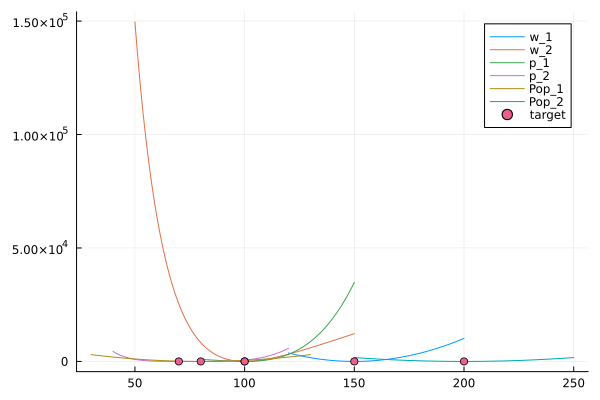

In [14]:
gr()
x1 = w_1_target-30:w_1_target+50
x2 = w_2_target-50:w_2_target+50
x3 = p_1_target-20:p_1_target+50
x4 = p_2_target-30:p_2_target+50
x5 = Pop_1_target-50:Pop_1_target+50
x6 = Pop_2_target-50:Pop_2_target+50
plot(x1, @.toy_model_new(x1, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_1")
plot!(x2, @.toy_model_new(w_1_target, x2, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_2")
plot!(x3, @.toy_model_new(w_1_target, w_2_target, x3, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_1")
plot!(x4, @.toy_model_new(w_1_target, w_2_target, p_1_target, x4, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_2")
plot!(x5, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, x5, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_1")
plot!(x6, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, x6, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_2")
plot!([w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target], [0, 0, 0, 0, 0, 0] ; label = "target", line = :scatter)

## test 2

In [22]:
w_1_target=150
w_2_target=100
p_1_target=100
p_2_target=70
Pop_1_target=80
Pop_2_target=200

200

In [23]:
theoretical_solution()

(100, 150, 70, 100, 200, 80, 0.5833333333333335, 0.004066666666666664, -1.6305306122448981, 0.014465306122448977, 1.6305306122448981, -0.014465306122448977, 2.3627961833179746e-26)

In [58]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = 0.583333333333325 
 α_2_init = 0.0040666666666667245 
 β_1_init = -1.6305306122448926 
 β_2_init = 0.01446530612244892 
 δ_1_init = 1.6305306122448926 
 δ_2_init = -0.01446530612244892 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.5960445245553285e-22    3.5960445245553285e-22
Dual infeasibility......:   

In [59]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

3.3286608181667166e-13

In [60]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = 0.5833333210016709 
 α_2_init = 0.004066666752782598 
 β_1_init = -1.6305306041258014 
 β_2_init = 0.014465306015683412 
 δ_1_init = 1.6305306041258014 
 δ_2_init = -0.014465306015683412 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.9788116788872083e-19    1.9788116788872083e-19
Dual infeasibility......: 

In [61]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

3.328662233370875e-13

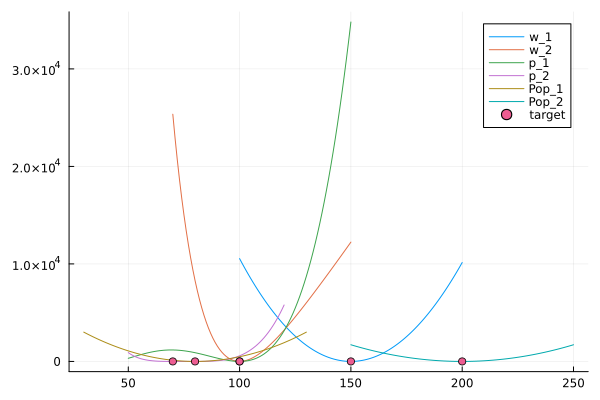

In [18]:
gr()
x1 = w_1_target-50:w_1_target+50
x2 = w_2_target-30:w_2_target+50
x3 = p_1_target-50:p_1_target+50
x4 = p_2_target-20:p_2_target+50
x5 = Pop_1_target-50:Pop_1_target+50
x6 = Pop_2_target-50:Pop_2_target+50
plot(x1, @.toy_model_new(x1, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_1")
plot!(x2, @.toy_model_new(w_1_target, x2, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_2")
plot!(x3, @.toy_model_new(w_1_target, w_2_target, x3, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_1")
plot!(x4, @.toy_model_new(w_1_target, w_2_target, p_1_target, x4, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_2")
plot!(x5, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, x5, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_1")
plot!(x6, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, x6, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_2")
plot!([w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target], [0, 0, 0, 0, 0, 0] ; label = "target", line = :scatter)

## test 3

In [24]:
w_1_target=70
w_2_target=200
p_1_target=30
p_2_target=130
Pop_1_target=100
Pop_2_target=150

150

In [25]:
theoretical_solution()

(70, 200, 30, 130, 100, 150, -2.806962323390895, 0.02240266875981161, -1.4531952662721892, 0.009106508875739645, 1.4531952662721892, -0.009106508875739645, 8.784755040541187e-26)

In [63]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = -2.8069623236561663 
 α_2_init = 0.02240266876102205 
 β_1_init = -1.4531952665030463 
 β_2_init = 0.009106508877464822 
 δ_1_init = 1.4531952665030463 
 δ_2_init = -0.009106508877464822 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.0348604026319354e-17    1.0348604026319354e-17
Dual infeasibility......: 

4.840684325018198e-13

In [64]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

7.507375090077368e-12

In [65]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -2.80696239002262 
 α_2_init = 0.02240266917265885 
 β_1_init = -1.4531952896507445 
 β_2_init = 0.009106509065856598 
 δ_1_init = 1.4531952896507445 
 δ_2_init = -0.009106509065856598 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.5379301640314297e-20    3.5379301640314297e-20
Dual infeasibility......:   

In [66]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

7.502312683879607e-12

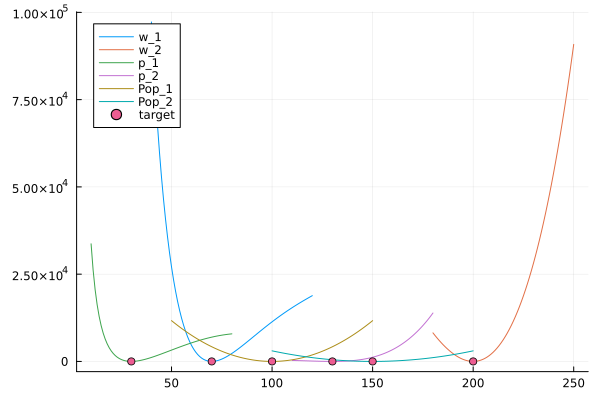

In [22]:
gr()
x1 = w_1_target-30:w_1_target+50
x2 = w_2_target-20:w_2_target+50
x3 = p_1_target-20:p_1_target+50
x4 = p_2_target-20:p_2_target+50
x5 = Pop_1_target-50:Pop_1_target+50
x6 = Pop_2_target-50:Pop_2_target+50
plot(x1, @.toy_model_new(x1, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_1")
plot!(x2, @.toy_model_new(w_1_target, x2, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "w_2")
plot!(x3, @.toy_model_new(w_1_target, w_2_target, x3, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_1")
plot!(x4, @.toy_model_new(w_1_target, w_2_target, p_1_target, x4, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "p_2")
plot!(x5, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, x5, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_1")
plot!(x6, @.toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, x6, α_1, α_2, β_1, β_2, δ_1, δ_2) ; label = "Pop_2")
plot!([w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target], [0, 0, 0, 0, 0, 0] ; label = "target", line = :scatter)

## Test 4

In [26]:
w_1_target=120
w_2_target=80
p_1_target=60
p_2_target=40
Pop_1_target=100
Pop_2_target=100

100

In [27]:
theoretical_solution()

(80, 120, 40, 60, 100, 100, -0.6458333333333336, 0.015729166666666662, -1.2666666666666666, 0.012666666666666666, 1.2666666666666666, -0.012666666666666666, 9.087677628146056e-27)

In [68]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = -0.6458333313179012 
 α_2_init = 0.015729166648153332 
 β_1_init = -1.2666666676412985 
 β_2_init = 0.012666666686739683 
 δ_1_init = 1.2666666676412985 
 δ_2_init = -0.012666666686739683 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   9.6323055663773793e-20    9.6323055663773793e-20
Dual infeasibility......:

6.3682968230837925e-15

In [69]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

2.1495267337379165e-12

In [70]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -0.6458333592613595 
 α_2_init = 0.01572916691897009 
 β_1_init = -1.2666667459244745 
 β_2_init = 0.012666667957386184 
 δ_1_init = 1.2666667459244745 
 δ_2_init = -0.012666667957386184 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.2278325145113113e-20    1.2278325145113113e-20
Dual infeasibility......: 

In [71]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

2.1295321701622687e-12

## Test 5

In [28]:
w_1_target=110
w_2_target=110
p_1_target=50
p_2_target=60
Pop_1_target=140
Pop_2_target=140

140

In [31]:
toy_model_new(110, 110, 50, 60, 140, 140, 0, 0, -2.35, 0.02837, 2.35, -0.02837)

38642.006596

In [29]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = 0.00010442412722439816 
 α_2_init = 0.011486653994840043 
 β_1_init = -2.3503333336372902 
 β_2_init = 0.028366666671972216 
 δ_1_init = 2.3503333336372902 
 δ_2_init = -0.028366666671972216 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   7.1984487174913201e-19    7.1984487174913201e-19
Dual infeasibility....

8.06166036169203e-14

In [74]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

2.9974150377793854e-12

In [75]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -0.36588103670659516 
 α_2_init = 0.01738496082565546 
 β_1_init = -2.9336667145795476 
 β_2_init = 0.040033334265396604 
 δ_1_init = 2.9336667145795476 
 δ_2_init = -0.040033334265396604 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.9773193499663773e-18    2.9773193499663773e-18
Dual infeasibility......:

In [76]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

2.997305720307938e-12

## Test 6

In [77]:
w_1_target=11000
w_2_target=9000
p_1_target=5000
p_2_target=6000
Pop_1_target=14000
Pop_2_target=14000

14000

In [78]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = -0.3458810325476869 
 α_2_init = 0.00017284960718293925 
 β_1_init = -2.9191466666666677 
 β_2_init = 0.00039901333333333347 
 δ_1_init = 2.9191466666666677 
 δ_2_init = -0.00039901333333333347 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.6543612251060553e-24    1.6543612251060553e-24
Dual infeasibility

6.2248484380943034e-18

In [79]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

2.7621248475466356e-14

In [80]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -0.3458916604967869 
 α_2_init = 0.00017667659791287743 
 β_1_init = -2.9191497741750485 
 β_2_init = 0.0004162649550215475 
 δ_1_init = 2.9191497741750485 
 δ_2_init = -0.0004162649550215475 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:   4.3388535977665609e-14    4.3388535977665609e-14
Dual infeasibility..

In [81]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

1.3494980215997436e-15

In [82]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -0.3459023378431567 
 α_2_init = 0.00018054996837050746 
 β_1_init = -2.919432905374792 
 β_2_init = 0.0020776465526284437 
 δ_1_init = 2.919432905374792 
 δ_2_init = -0.0020776465526284437 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:   7.3828112866475091e-13    7.3828112866475091e-13
Dual infeasibility....

In [83]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

3.0899232698214827e-12

## Test 7

In [84]:
w_1_target=1.1
w_2_target=.9
p_1_target=.5
p_2_target=.6
Pop_1_target=1.4
Pop_2_target=1.4

1.4

In [85]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = -2.3658810174550893 
 α_2_init = 2.7384960586029954 
 β_1_init = -4.385666692225848 
 β_2_init = 5.3233333819895305 
 δ_1_init = 4.385666692225848 
 δ_2_init = -5.3233333819895305 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   1.2749944065827311e-10    1.2749944065827311e-10
Dual infeasibility......:   3.12

1.0715005893270203e-9

In [86]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

6.166479174551734e-6

In [87]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -2.3666426122684032 
 α_2_init = 2.725145117271744 
 β_1_init = -4.58467793040009 
 β_2_init = 5.602294592624603 
 δ_1_init = 4.58467793040009 
 δ_2_init = -5.602294592624603 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   3.9783343268713523e-13    3.9783343268713523e-13
Dual infeasibility......:   9.2341875

In [88]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

1.1689590127360228e-7

## Test 8

In [89]:
w_1_target = 10
w_2_target = 100
p_1_target = 10
p_2_target = 100
Pop_1_target = 200
Pop_2_target = 100

100

In [90]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = -179.9988888986495 
 α_2_init = 1.9898888889748447 
 β_1_init = -3.3606666664350184 
 β_2_init = 0.03206666666297958 
 δ_1_init = 3.3606666664350184 
 δ_2_init = -0.03206666666297958 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   5.8203946052260890e-17    5.8203946052260890e-17
Dual infeasibility......:   7

9.371368432037278e-14

In [91]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -2.36989788917842 
 α_2_init = 2.7353723064553197 
 β_1_init = -4.6041782211817575 
 β_2_init = 5.629583246498626 
 δ_1_init = 4.6041782211817575 
 δ_2_init = -5.629583246498626 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   6.1288644670969279e-14    6.1288644670969279e-14
Dual infeasibility......:   5.0073

In [92]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

1.1118828441782767e-7

## Test 9

In [93]:
w_1_target = 687
w_2_target = 936
p_1_target = 737
p_2_target = 363
Pop_1_target = 566
Pop_2_target = 257

257

In [94]:
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2)

 α_1_init = 0.609703075093509 
 α_2_init = -0.0001250296468471545 
 β_1_init = -0.4370350272474741 
 β_2_init = 0.0004465546676247073 
 δ_1_init = 0.4370350272474741 
 δ_2_init = -0.0004465546676247073 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   6.2975586479134802e-24    6.2975586479134802e-24
Dual infeasibility....

7.549335891417572e-19

In [95]:
w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target = w_1, w_2, p_1, p_2, Pop_1, Pop_2
α_1, α_2, β_1, β_2, δ_1, δ_2 = toy_model_outer_solve()
println("With this values, Loss = ", toy_model_new(w_1_target, w_2_target, p_1_target, p_2_target, Pop_1_target, Pop_2_target, α_1, α_2, β_1, β_2, δ_1, δ_2))

 α_1_init = -2.370210676723991 
 α_2_init = 2.7357218880407284 
 β_1_init = -4.605386676232948 
 β_2_init = 5.631740906073804 
 δ_1_init = 4.605386676232948 
 δ_2_init = -5.631740906073804 
Model initialized

Total number of variables............................:       12
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   1.3021801383615941e-12    1.3021801383615941e-12
Dual infeasibility......:   1.19245

In [96]:
w_1, w_2, p_1, p_2, Pop_1, Pop_2 = toy_model_pop_solve(α_1, α_2, β_1, β_2, δ_1, δ_2)
toy_model_new(w_1, w_2, p_1, p_2, Pop_1, Pop_2, α_1, α_2, β_1, β_2, δ_1, δ_2)

Begin solver execution
Initializing model in solver
Model initialized
Launching optimization
This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

4.417039272028684e-9